## KDE example with contour plot

The Notebook follows the calculation related to the work [Folding Kinetics of an Entangled Protein](https://doi.org/10.1101/2023.04.17.537117 ) in open-access on BiorXiv.

We will load two 1D arrays, each containing the information relative to an observable (reaction coordinate). These arrays have the form of concatenated timeseries. Here we will ignore the time dependency and focus only on which values are sampled by the system, in order to plot them. 

In [1]:
from pathlib import Path

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from kde_contour import kde, contour_custom

# Auxiliary function
def timeseries_mask(
    r: int,
    t: np.ndarray
    ) -> np.ndarray:
    '''Return a mask applicable to timeseries t;
    The first and the last point in the timeseries are selected

    Please note that if you want to use mask for fancy indexing
    you need to use np.nonzero(mask) instead'''

    assert t.ndim == 1

    mask = np.zeros(t.size, dtype=int)
    block = mask.size//r
    for i in range(r):
        mask[i*block] = 1
    mask[-1] = 1 # include last frame

    return mask

In [2]:
# Define paths
prot_name = '1ucs'
DATA = Path('data/')

### Load the necessary data from `data` directory
Q and GE_traj are a collection of timeseries that we first load and then, for each one, we transform into a single, flat, array. 

In [3]:
# Other information needed for the analysis of the observables
cm_native = np.load(DATA / f'{prot_name}_cm.npy')
cm_native = np.triu(cm_native)
total_contacts = (cm_native != 0).sum()
GE_native = np.load(DATA / f'GE_{prot_name}_native.npy', allow_pickle=True)

# Load first observable
QPATH = DATA / 'Q_8Nov22_CV.npy'
Q = np.load(QPATH)

# load second observable
ge_mode = 'wGEa_threshold_0.50_exponent_4.00'
GE_PATH = DATA / f'{ge_mode}_r3000_8Nov22_CV.npy'
GE_traj = np.load(GE_PATH, allow_pickle=True)

In [4]:
# Flattening
Q_forHist = np.array([])
GE_forHist = np.array([])

# Undersampling mask (original data is at too high resolution)
mask = timeseries_mask(3000, Q[0])
nonzero_mask = np.flatnonzero(mask)

for q, ge in zip(Q, GE_traj):
    q_temp = q[nonzero_mask]

    Q_forHist = np.concatenate((Q_forHist, q_temp))
    GE_forHist = np.concatenate((GE_forHist, ge))

# force casting from object to float in order to use KDE
# Required by: scipy
GE_forHist = GE_forHist.astype(float)

## KDE representation

This plot perform a KDE in order to better visualize the trajectories. It is the result of the knowledge acquire from the `KernelEstimate` function from `sklearn`, the one implemented in `scipy.stats.gaussian_kde` and the visualizazion provided in `seaborn` for the contourn plot.

Key factors for the KDE:
- the non-parametric estimation has one single hyper-parameters, the bandwidth. Choose this parameter is quite hard and the following is was observe to highlight the features of the profile: the `scott` "rule-of-thumb" is used, which consist in estimating the bw as `number of sample ** (-1/(dimentions + 4))` times the standard deviation of the sample. In each dimention, a difference std can be implemented. The computation is handled by the `scipy.stats.gaussian_kde` function. This is not as flexible as the one implemented in `sklearn`, but conveniently implements different bw for each dimention (contrary to the `sklearn` function). Note that the documentation for the former is not that clear about this aspect. Nevertheless, in this case is useful
- the `thresh` keyword helps in the visualization by removing the highest contours

In [5]:
# graphical settings
matplotlib.rcParams['font.size'] = 24
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'modern computer'

In [6]:
# This computations takes approx 1 minutes and 30 sec
X, Y, Z, kernel = kde(
    Q_forHist,  # first coordinate
    GE_forHist,  # second coordinate
    'scott',  # method to select the bandwidth (see scipy.stats.gaussian_kde)
    300,  # number of points along one direction in which evaluate the KDE
    {"xmin":0, "xmax":1, "ymin":-1.5, "ymax":1.5})  # extrema of the KDE evaluation

# transform the KDE in a log scale adn shift to have the minimum at 0
m_logZ = -np.log(Z) + abs((-np.log(Z)).min())


    Covariance factor = 0.1861832768167746; bw = cf*std:
    For x: 0.049976227552605904
    For y: 0.07402654524895771

    


/tmp/ipykernel_39378/3660011520.py:10: RuntimeWarning: divide by zero encountered in log
  m_logZ = -np.log(Z) + abs((-np.log(Z)).min())


In [7]:
# Consistency check: integral must me close to 1
# NOTE: it might take a while
from scipy.integrate import dblquad
def kde_wrapper(y,x):
    return kernel.evaluate(np.array([x, y])[:,None])

dblquad(kde_wrapper, 0, 1, 0, 1.2)

(0.2416054859877088, 1.3891197563033244e-08)

### Plotting

Levels lower bounds:
[0.  0.4 0.8 1.2 1.6 2.  2.4 2.8 3.2 3.6 4.  4.4 4.8 5.2]
Using CMAP


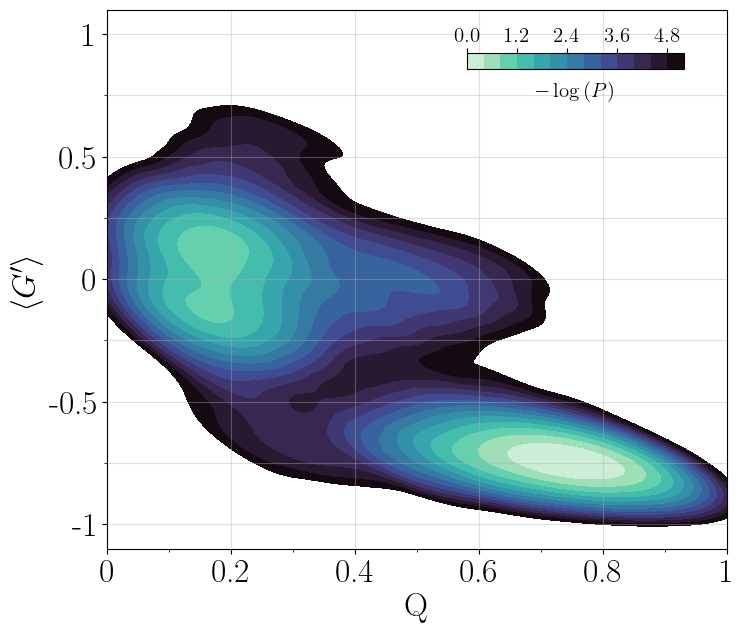

In [8]:
# Use case 1
plot_params = {
    "levels_difference": 0.4,
    "last_level": 5.2,
    "cmap": sns.color_palette("mako_r", as_cmap=True),
    "xlabel": "Q",
    "ylabel": r"$\langle G^\prime \rangle$",
    "y_major_locator": [-1, -0.5, 0, 0.5, 1],
    "y_major_formatter": ['-1', '-0.5', '0','0.5','1'],
    "y_minor_locator": 0.25,
    "x_major_locator": [0, 0.2, 0.4, 0.6, 0.8, 1],
    "x_major_formatter": ['0', '0.2','0.4','0.6','0.8','1'],
    "x_minor_locator": 0.1,
    "cbar": True,
    "cbar_position": 'upper right',
    "cbar_label": "$-\\log \left( P \\right)$",
    "cbar_ticks_every_jump": 3,
    "cbar_labelpad": -50,
    "cbar_fontsize": 15,
    "cbar_labelsize": 15,
    "cbar_ticks_position": "top"
}

fig, ax = plt.subplots(1, figsize=(8,7))
CS = contour_custom(
    X,Y,m_logZ,  # x coordinate, y coordinate and KDE evaluated in the (x,y) points
    ((0,1),(-1.1,1.1)),  # limits of the plot
    ax, fig,
    plot_params)

plt.show()

Levels lower bounds:
[0.  0.4 0.8 1.2 1.6 2.  2.4 2.8 3.2 3.6 4.  4.4 4.8 5.2]
Loading colors from ./data/mako_shifted_colormapList.txt


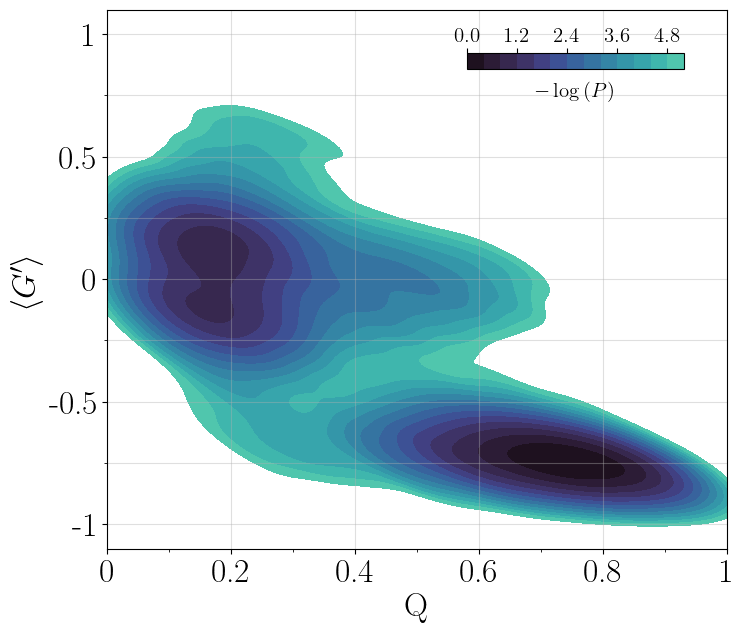

In [9]:
# Use case 2
# Plotting
plot_params = {
    "levels_difference": 0.4,
    "last_level": 5.2,
    "cmap": "./data/mako_shifted_colormapList.txt",
    "xlabel": "Q",
    "ylabel": r"$\langle G^\prime \rangle$",
    "y_major_locator": [-1, -0.5, 0, 0.5, 1],
    "y_major_formatter": ['-1', '-0.5', '0','0.5','1'],
    "y_minor_locator": 0.25,
    "x_major_locator": [0, 0.2, 0.4, 0.6, 0.8, 1],
    "x_major_formatter": ['0', '0.2','0.4','0.6','0.8','1'],
    "x_minor_locator": 0.1,
    "cbar": True,
    "cbar_position": 'upper right',
    "cbar_label": "$-\\log \left( P \\right)$",
    "cbar_ticks_every_jump": 3,
    "cbar_labelpad": -50,
    "cbar_fontsize": 15,
    "cbar_labelsize": 15,
    "cbar_ticks_position": "top"
}

fig, ax = plt.subplots(1, figsize=(8,7))
CS = contour_custom(
    X,Y,m_logZ,
    ((0,1),(-1.1,1.1)),
    ax, fig,
    plot_params)

plt.show()

fig.savefig('assets/example.png', dpi=300, bbox_inches='tight')